In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import hist

BaseSchema.warn_missing_crossrefs = False

fname_bib = "bib_trk_all.root"
events_bib = NanoEventsFactory.from_root(
    fname_bib,
    treepath="MyLCTuple",
    schemaclass=BaseSchema,
).events()

In [2]:
nsystems = 7
nmaxlayers = 8

events_bib["system"] = events_bib.stci0 & 31
events_bib["layer"] = (events_bib.stci0 >> 7) & 63
events_bib["side"] = (events_bib.stci0 >> 5) & 3

events_bib["stpor"] = np.sqrt(events_bib.stpox*events_bib.stpox + events_bib.stpoy*events_bib.stpoy)

events_bib["corrT"] = events_bib.sttim - np.sqrt(events_bib.stpox*events_bib.stpox
                                                 + events_bib.stpoy*events_bib.stpoy
                                                 + events_bib.stpoz*events_bib.stpoz)*(10**6)/(2.99792458 * 10**8)

In [3]:
hitarea = []
hitareawind = []
exclude1 = (events_bib.system % 2 != 0) + (abs(events_bib.stpoz) > 6)
exclude2 = (events_bib.system != 3) + (events_bib.layer != 0) + (events_bib.stpor > 126)*(events_bib.stpor < 200)
exclude3 = (events_bib.system != 5) + (events_bib.stpor > 816)
exclude = exclude1*exclude2*exclude3
ctcond = (events_bib.corrT >= -0.36)*(events_bib.corrT <= 0.48)
for system in range(1, nsystems):
    if (system % 2) == 1:
        sides = [0]
    else:
        sides = [1, 3]
    if system < 3:
        res = 0.03
    else:
        res = 0.06
    ctcond2 = (events_bib.corrT >= -3*res)*(events_bib.corrT <= 5*res)
    for side in sides:
        maxlayers = ak.max(events_bib.layer[(events_bib.system == system)*(events_bib.side == side)])
        for layer in range(0, maxlayers+1):
            cond = (events_bib.system == system)*(events_bib.layer == layer)*(events_bib.side == side)
            cond2 = cond*exclude
            rmin = ak.min(events_bib.stpor[cond2])
            rmax = ak.max(events_bib.stpor[cond2])
            zmin = ak.min(events_bib.stpoz[cond2])
            zmax = ak.max(events_bib.stpoz[cond2])
            num = ak.sum(cond2*ctcond)
            numwindow = ak.sum(cond2*ctcond2)
            if (system % 2) == 1:
                area = 2*np.pi*rmin*(zmax-zmin)/100
                hitarea.append(num/area)
                hitareawind.append(numwindow/area)
            else:
                area = np.pi*(rmax*rmax - rmin*rmin)/100
                hitarea.append(num/area)
                hitareawind.append(numwindow/area)

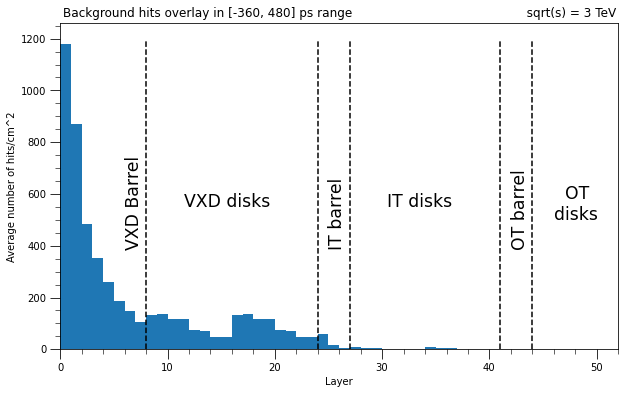

In [4]:
hitarea = ak.Array(hitarea)
h = hist.Hist(hist.axis.Regular(53, -1, 52))
h.fill(list(range(0, len(hitarea))), weight=hitarea)
fig = plt.figure(figsize=(10,6))
h.plot(histtype="fill")
plt.xlabel('Layer')
plt.ylabel('Average number of hits/cm^2')
plt.title('Background hits overlay in [-360, 480] ps range                                             sqrt(s) = 3 TeV')
plt.vlines([8, 24, 27, 41, 44], 0, 1200, colors='k', linestyles='dashed')
plt.text(6, 400, 'VXD Barrel', rotation='vertical', fontsize='xx-large')
plt.text(11.5, 550, 'VXD disks', fontsize='xx-large')
plt.text(25, 400, 'IT barrel', rotation='vertical', fontsize='xx-large')
plt.text(30.5, 550, 'IT disks', fontsize='xx-large')
plt.text(42, 400, 'OT barrel', rotation='vertical', fontsize='xx-large')
plt.text(46, 500, '  OT\ndisks', fontsize='xx-large')
plt.xlim(0, 52)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='out', length=10, labelbottom=True)
plt.tick_params(axis='both', which='minor', direction='out', length=5)
#plt.savefig("plots11-11/hitsperarea.png")
plt.show()

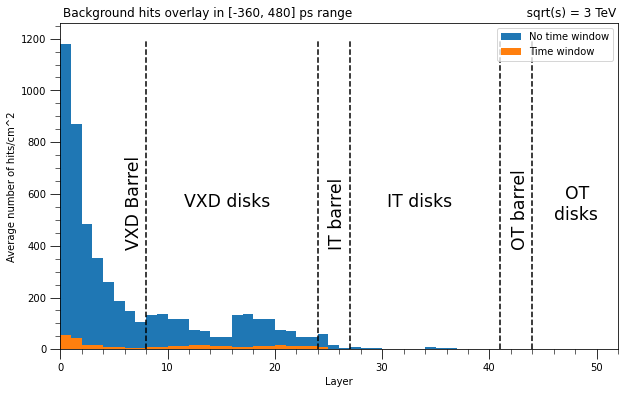

In [5]:
ax = hist.axis.Regular(53, -1, 52, name='layer')
cat_ax = hist.axis.StrCategory(['Time window', 'No time window'], name='wind')
full_hist = hist.Hist(ax, cat_ax)
    
full_hist.fill(layer=list(range(0, len(hitarea))), wind='No time window', weight=hitarea)
full_hist.fill(layer=list(range(0, len(hitareawind))), wind='Time window', weight=hitareawind)
h = full_hist.stack("wind")
fig = plt.figure(figsize=(10, 6))

h[::-1].plot(stack=False, histtype="fill")
plt.xlabel('Layer')
plt.ylabel('Average number of hits/cm^2')
plt.legend()
plt.title('Background hits overlay in [-360, 480] ps range                                             sqrt(s) = 3 TeV')
plt.vlines([8, 24, 27, 41, 44], 0, 1200, colors='k', linestyles='dashed')
plt.text(6, 400, 'VXD Barrel', rotation='vertical', fontsize='xx-large')
plt.text(11.5, 550, 'VXD disks', fontsize='xx-large')
plt.text(25, 400, 'IT barrel', rotation='vertical', fontsize='xx-large')
plt.text(30.5, 550, 'IT disks', fontsize='xx-large')
plt.text(42, 400, 'OT barrel', rotation='vertical', fontsize='xx-large')
plt.text(46, 500, '  OT\ndisks', fontsize='xx-large')
plt.xlim(0, 52)
plt.minorticks_on()
plt.tick_params(axis='both', which='major', direction='out', length=10, labelbottom=True)
plt.tick_params(axis='both', which='minor', direction='out', length=5)
#plt.savefig("plots12-02/hitsperarea.png")
plt.show()
